### Example script for running IBS
##### Example 1: Orientation Discrimination
We use data generated from simple discrimination orientation model and calculate its log-likelihood using IBS.
Because the analytical log-likelihood of this model is available, one can compare the results and verify the unbiasedness of the IBS estimator.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from ibs import IBS
from psycho_gen import psycho_gen
from psycho_nll import psycho_nll

In [4]:
# Set up a psychometric function model of a simple orientation discrimination task

sample_from_model = psycho_gen
num_trials = 600
eta = np.log(1)  # Fake subject (log) sensory noise
bias = 0.2  # Fake subject response bias
lapse = 0.03  # Fake subject lapse rate
# Generating parameter vector
params = np.array([eta, bias, lapse])

# Generate stimulus orientation per trial
design_matrix = 3 * npr.rand(num_trials)
# Generate fake subject responses
response_matrix = psycho_gen(params, design_matrix)

# Create an ibs object and set up most of the options

# IBS object with vectorized computation
ibs = IBS(
    sample_from_model,
    response_matrix,
    design_matrix,
    vectorized=True,
    acceleration=1.5,
    num_samples_per_call=0,
    max_iter=int(1e5),
    max_time=np.inf,
)
# IBS object with loop computation
ibs_loop = IBS(
    sample_from_model,
    response_matrix,
    design_matrix,
    vectorized=False,
    acceleration=1.5,
    num_samples_per_call=0,
    max_iter=int(1e5),
    max_time=np.inf,
)

# Call the IBS object to compute an estimate. We can pass additional options like what additional output we want
neg_logl, neg_logl_var = ibs(
    params,
    num_reps=10,
    trial_weights=None,
    additional_output="var",
    return_positive=False,
)
neg_logl_loop, neg_logl_var_loop = ibs_loop(
    params,
    num_reps=10,
    trial_weights=None,
    additional_output="var",
    return_positive=False,
)
output = ibs(
    params,
    num_reps=10,
    trial_weights=None,
    additional_output="full",
    return_positive=False,
)


# Comparing estimated results to the true value
print("estimated negative log-likelihood", neg_logl)
print("estimated variance", neg_logl_var)
print("estimated negative log-likelihood (loop)", neg_logl_loop)
print("estimated variance (loop)", neg_logl_var_loop)
print(
    "exact log-likelihood", psycho_nll(params, design_matrix, response_matrix)
)
print("-------------------------------------------")
print(output)

estimated negative log-likelihood 221.05348103196098
estimated variance 17.085697848865586
estimated negative log-likelihood (loop) 225.17023331874864
estimated variance (loop) 17.189282517605932
exact log-likelihood 221.43724801917898
-------------------------------------------
              neg_logl: 221.36214641754725
          neg_logl_var: 17.04591810254807
          neg_logl_std: 4.128670258394108
             exit_flag: 0
               message: 'Correct termination (the estimate is unbiased).'
          elapsed_time: 0.004196499999999048
 num_samples_per_trial: 1.855
             fun_count: 6


We want to check the unbiasedness of the estimator by demonstrating that the log-likelihood estimates are centred around the true value.
For 1000 different values of the parameter theta the estimate of the log-likelihood and its standard deviation are calculated using IBS and then the standard score (z-score) of the estimate is calculated. A histogram of the z-scores is plotted. The z-scores should approximate a standard normal distribution (mean 0, SD 1).

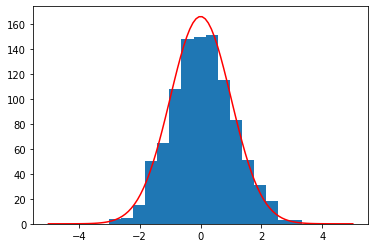

In [5]:
sample_from_model = psycho_gen
num_trials = 600
eta = np.linspace(np.log(0.01), np.log(1), num=10)
bias = np.linspace(0.05, 0.3, num=10)
lapse = np.linspace(0.005, 0.05, num=10)
params = np.array(np.meshgrid(eta, bias, lapse)).T.reshape(-1, 3)
design_matrix = 3 * npr.rand(num_trials)
num_experiments = params.shape[0]
z_scores = np.zeros(num_experiments)

for i in range(num_experiments):
    response_matrix = psycho_gen(params[i], design_matrix)
    ibs = IBS(
        sample_from_model,
        response_matrix,
        design_matrix,
        vectorized=True,
        acceleration=1.5,
        num_samples_per_call=0,
        max_iter=int(1e5),
        max_time=np.inf,
    )
    neg_logl, neg_logl_std = ibs(
        params[i],
        num_reps=10,
        trial_weights=None,
        additional_output="std",
        return_positive=True,
    )
    neg_logl_exact = psycho_nll(params[i], design_matrix, response_matrix)
    z_scores[i] = (neg_logl_exact + neg_logl) / neg_logl_std


plt.hist(z_scores, bins=16, density=False)
# Plot standard normal distribution in the same graph
x = np.linspace(-5, 5, 100)
plt.plot(
    x,
    (num_experiments * 5 / 6) * np.exp(-(x**2) / 2) / np.sqrt(2 * np.pi) / 2,
    color="red",
)
plt.show()

if np.abs(np.mean(z_scores)) > 0.15:
    print("Warning: the mean of the z-scores is not close to zero")
if np.abs(np.std(z_scores) - 1) > 0.1:
    print(
        "Warning: the standard deviation of the z-scores is not close to one"
    )

##### Example 2: Binomial Model
Using IBS to compute log(p) of Bernoulli distribution with 1000 repeats. One can observe that the IBS estimates are close to the true value and calibrated.


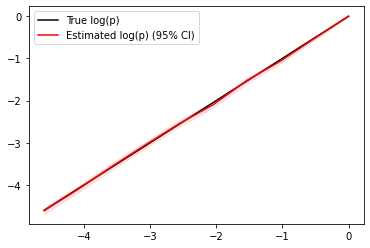

In [6]:
num_reps = 1000

# Binomial probability model
p_model = np.exp(np.linspace(np.log(0.01), np.log(1), num=10))


def sample_from_model(x, design_matrix):
    if design_matrix is None:
        return int(np.random.rand(1) < x)
    else:
        return np.vectorize(int)(np.random.rand(design_matrix.size) < x)


response_matrix = sample_from_model(1, None)
neg_logl = np.zeros(len(p_model))
neg_logl_std = np.zeros(len(p_model))
ibs = IBS(
    sample_from_model,
    response_matrix,
    None,
    vectorized=True,
    acceleration=1.5,
    num_samples_per_call=0,
    max_iter=int(1e5),
    max_time=np.inf,
)

for i in range(len(p_model)):
    neg_logl[i], neg_logl_std[i] = ibs(
        p_model[i],
        num_reps=num_reps,
        trial_weights=None,
        additional_output="std",
        return_positive=True,
    )

# We expect the true value to be almost certainly in this range
LL_min = neg_logl - 4 * neg_logl_std
LL_max = neg_logl + 4 * neg_logl_std
if np.any(np.log(p_model) < LL_min) or np.any(np.log(p_model) > LL_max):
    print("Warning: true value is not in the confidence interval")

# Plot the true log(p) vs the estimated log(p)
plt.plot(np.log(p_model), np.log(p_model), color="black")
plt.plot(np.log(p_model), neg_logl, color="red")
plt.fill_between(
    np.log(p_model),
    neg_logl - 1.96 * neg_logl_std,
    neg_logl + 1.96 * neg_logl_std,
    color="red",
    alpha=0.1,
)
plt.legend(["True log(p)", "Estimated log(p) (95% CI)"])
plt.show()

We use IBS to compute the log-likelihood of a binomial distribution with 100 trials per each of the 2000 experiments. The z-scores of each estimate are calculated. We can observe that the z-scores follow approximately a standard normal distribution (mean 0, SD 1).

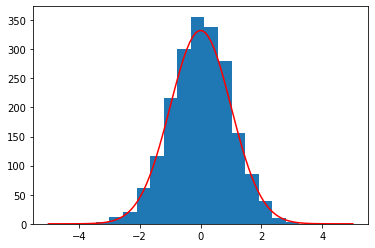

In [7]:
num_trials = 100

# Binomial probability model
p_model = 0.9 * np.random.rand() + 0.05
p_true = 0.9 * np.random.rand() + 0.05


def sample_from_model(x, design_matrix):
    if design_matrix is None:
        return int(np.random.rand(1) < x)
    else:
        return np.random.rand(np.size(design_matrix)) < x


num_experiments = 2 * 10**3
z_scores = np.zeros(num_experiments)
for i in range(num_experiments):
    response_matrix = sample_from_model(p_true, np.zeros(num_trials))
    ibs = IBS(
        sample_from_model,
        response_matrix,
        None,
        vectorized=True,
        acceleration=1.5,
        num_samples_per_call=0,
        max_iter=int(1e5),
        max_time=np.inf,
    )
    neg_logl, neg_logl_std = ibs(
        p_model,
        num_reps=10,
        trial_weights=None,
        additional_output="std",
        return_positive=True,
    )
    neg_logl_exact = np.log(p_model) * np.sum(response_matrix) + np.log(
        1 - p_model
    ) * np.sum(response_matrix == False)
    z_scores[i] = (neg_logl_exact - neg_logl) / neg_logl_std
plt.hist(z_scores, bins=16, density=False)
# plot standard normal distribution in the same graph
x = np.linspace(-5, 5, 100)
plt.plot(
    x,
    (num_experiments * 5 / 6) * np.exp(-(x**2) / 2) / np.sqrt(2 * np.pi) / 2,
    color="red",
)
plt.show()

if np.abs(np.mean(z_scores)) > 0.15:
    print("Warning: the mean of the z-scores is not close to zero")
if np.abs(np.std(z_scores) - 1) > 0.1:
    print(
        "Warning: the standard deviation of the z-scores is not close to one"
    )